In [67]:
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
import seaborn as sns
from datetime import date, timedelta, datetime
import os
import common_functions as cf
from scipy import stats

In [68]:
def convert_name(col):
    return col.split()[0][0]+col.split()[1][0]


In [69]:
downloads_path = "C:\\Users\\Hannah Nevel\\Downloads"

all_investments_filepath = downloads_path +"\\All Investments 2023-2024-2024-02-21-14-12-44.xlsx"
all_conversions_filepath = downloads_path + "\\All Conversions 2023-2024-2024-02-21-14-12-38.xlsx"

investments_filepath = downloads_path + "\\CM Report  Year to Date Investments-2024-02-23-08-16-11.xlsx"
conversions_filepath = downloads_path+ "\\Year to Date Conversions Schedule-2024-02-23-08-16-52.xlsx"

calendly_ytd_filepath = downloads_path + "\\events-export 2-23-2024.csv"
phoneburner_YTD_filepath = downloads_path + "\\usage 2-23-2024.csv"
dialpad_ytd_filepath = downloads_path + "\\ytd dialpads - 20240222.csv"

presstwos_ytd_filepath = downloads_path + "\\press 2s back to sep 1 -20240215.csv"
contacts_sf_filepath = downloads_path + "\\All Contacts.csv"


all_investments = pd.read_excel(all_investments_filepath)
all_conversions = pd.read_excel(all_conversions_filepath)
ytd_investments = pd.read_excel(investments_filepath)
ytd_conversions = pd.read_excel(conversions_filepath)
ytd_phoneburner_data = pd.read_csv(phoneburner_YTD_filepath)
ytd_calendlys = pd.read_csv(calendly_ytd_filepath)
ytd_presstwos = pd.read_csv(presstwos_ytd_filepath)
ytd_dialpad_calls = pd.read_csv(dialpad_ytd_filepath)
contacts = pd.read_csv(contacts_sf_filepath, encoding='ISO-8859-1')


C:\Users\Hannah Nevel\AppData\Local\Temp\ipykernel_33068\1272041745.py:18: DtypeWarning: Columns (10,29,31,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  ac_data = pd.read_csv(ac_data_filepath)
c:\Users\Hannah Nevel\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Hannah Nevel\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Hannah Nevel\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's 

In [70]:
def replace_firstchar(string, index, newchar):
    if string[0] == '1':
        new_string = string[:index] + newchar + string[index+1:]
    else:
        new_string = string
    return new_string

x= '12345675555'
x = replace_firstchar(x,0,'')

In [75]:
#filter call data
ytd_dialpad_calls = ytd_dialpad_calls[(ytd_dialpad_calls['category'] != 'abandoned') & (ytd_dialpad_calls['category'] != 'cancelled') &  (ytd_dialpad_calls['category'] != 'missed')]
ytd_phoneburner_data = ytd_phoneburner_data[ytd_phoneburner_data['User'] != 'Sean Goodnight']
ytd_phoneburner_data = ytd_phoneburner_data.loc[(ytd_phoneburner_data['Notes'] != '' ) & (ytd_phoneburner_data['Notes'].str.contains('There are no valid phone numbers') == False)\
                                                        & (ytd_phoneburner_data['Notes'].str.contains("They can't be called at this time") == False) & (ytd_phoneburner_data['Live Answer'] == 1)]
#rename columns needed for merging
all_investments.rename(mapper={'Confirmed Email Addresses':'Email'}, axis=1, inplace=True)

ytd_dialpad_calls.rename({'external_number':'Phone Number'}, axis=1, inplace=True)

ytd_phoneburner_data.rename(mapper={'Email Address':'Lead Email','Phone':'Phone Number'}, axis=1, inplace=True)

#change dtype and concat call data
ytd_phoneburner_data['Phone Number'] = ytd_phoneburner_data['Phone Number'].astype(str)

ytd_phone_calls = pd.concat([ytd_phoneburner_data, ytd_dialpad_calls])

In [173]:
ytd_calendlys = ytd_calendlys.loc[(ytd_calendlys['User Name'] != 'Matt Willer') & (ytd_calendlys['Canceled'] != 'TRUE')]

ytd_investments = ytd_investments[ytd_investments['Investment Owner'] != 'Matt Willer']
ytd_investments['Conversion Check'] = ytd_investments['Investment Id'].isin(ytd_conversions['Conversion Child ID'])
ytd_newcapital = ytd_investments[(ytd_investments['Conversion Check'] == False) & (ytd_investments['Payment Method'] != 'Existing Investment') & (ytd_investments['Stage'] != 'Early Redemption')]
ytd_created = ytd_newcapital.loc[ytd_investments['Stage'] == 'Created']
ytd_newcapital = ytd_newcapital.loc[(ytd_newcapital['Stage'] == 'Settled') | (ytd_newcapital['Stage'] == 'Funded')]

today = date.today()
sixty_daysago = today - timedelta(days=60)
current_year = datetime.now().year
ytd_newcapital['Created Date'] = pd.to_datetime(ytd_newcapital['Created Date'])
ytd_newcapital['New Investor'] = (ytd_newcapital['Created Date'].dt.date >= sixty_daysago)  &  (ytd_newcapital['Call Notes'].str.contains('"wife of"|"Wife of"|"Husband of"|"husband of"|"spouse of"') == False)
ytd_newinvestors = ytd_newcapital.loc[(ytd_newcapital['Created Date'].dt.date >= sixty_daysago)]


ytd_calendlys.rename(mapper={'Invitee Email':'Lead Email'}, axis=1, inplace = True)
ytd_newcapital.rename(mapper={'Confirmed Email Addresses':'Lead Email'}, axis=1, inplace=True)


# ytd_dialpad_calls['Press 2'] = ytd_dialpad_calls['call_id'].isin(ytd_presstwos['call_id'])

# invested_contacts = contacts[contacts['Investment Disposition'] == 'Invested']

# #df of press 2 nums 
# presstwo_nums = ytd_dialpad_calls[ytd_dialpad_calls['Press 2'] == True]

# presstwo_nums['external_number'] = presstwo_nums['external_number'].astype(str)
# invested_contacts['Phone'] = invested_contacts['Phone'].astype(str)
# presstwos_inSF = presstwo_nums[presstwo_nums['external_number'].str.contains('|'.join(invested_contacts['Phone']))]
# for num in invested_contacts['Phone']:

#     accounts_with_presstwos = invested_contacts['Phone'].str.contains(num) & presstwo_nums['external_number'].str.contains(num)

C:\Users\Hannah Nevel\AppData\Local\Temp\ipykernel_10060\3266689698.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytd_phone_calls.rename(mapper={'Email Address':'Lead Email'}, axis=1, inplace=True)
C:\Users\Hannah Nevel\AppData\Local\Temp\ipykernel_10060\3266689698.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invested_contacts['Phone'] = invested_contacts['Phone'].astype(str)


In [174]:
ytd_calls_byuser = ytd_phone_calls.groupby('User').agg({'Phone':'nunique'}).reset_index()
ytd_calendlys_byuser = ytd_calendlys.groupby('User Name')['Lead Email'].nunique().reset_index()
ytd_dialpads_byuser = ytd_dialpad_calls.groupby('name')['external_number'].nunique().reset_index()
ytd_investments_byuser = ytd_newcapital.groupby('Investment Owner').agg({'Total Investment':'count'}).reset_index()
ytd_newinvestors_byuser = ytd_newcapital.groupby('Investment Owner').agg({'New Investor':'sum'}).reset_index()
ytd_created_byuser = ytd_created.groupby('Investment Owner')['Total Investment'].count().reset_index()


In [175]:
ytd_dialpads_byuser.rename(mapper={'name':'User','Lead Email':'Calendlys'},axis=1, inplace=True)
ytd_calendlys_byuser.rename(mapper={'User Name':'User','Lead Email':'Calendlys'},axis=1, inplace=True)
ytd_created_byuser.rename(mapper={'Investment Owner':'User','Total Investment':'Open Deals'},axis=1, inplace=True)
ytd_investments_byuser.rename(mapper={'Investment Owner':'User','Total Investment':'Closed Deals'},axis=1, inplace=True)
ytd_newinvestors_byuser.rename(mapper={'Investment Owner':'User','Total Investment':'Closed Deals'},axis=1, inplace=True)


In [176]:
ytd_dialpads_byuser['User'] = ytd_dialpads_byuser['User'].apply(lambda x: convert_name(x))
ytd_calendlys_byuser['User'] = ytd_calendlys_byuser['User'].apply(lambda x: convert_name(x))
ytd_calls_byuser['User'] = ytd_calls_byuser['User'].apply(lambda x: convert_name(x))
ytd_calendlys_byuser.loc[ytd_calendlys_byuser['User'] == 'DS', 'User'] = 'DG'
ytd_investments_byuser['User'] = ytd_investments_byuser['User'].apply(lambda x: convert_name(x))
ytd_newinvestors_byuser['User'] = ytd_newinvestors_byuser['User'].apply(lambda x: convert_name(x))
ytd_created_byuser['User'] = ytd_created_byuser['User'].apply(lambda x: convert_name(x))

In [177]:
ytd_created_byuser

,User,Open Deals
0,AW,1
1,BP,5
2,CS,4
3,CC,1
4,DG,3
5,PM,1
6,TA,3


In [178]:
conversion_data = ytd_calendlys_byuser.merge(ytd_calls_byuser, on='User', how='outer').merge(ytd_dialpads_byuser, on='User',how='outer').merge(ytd_investments_byuser, on='User', how='outer')\
    .merge(ytd_newinvestors_byuser, on='User', how='outer').merge(ytd_created_byuser, on='User', how='outer').fillna(0)
conversion_data.rename(mapper={'external_number':'Dialpad Calls','Phone':'PB Calls'},axis=1, inplace=True)

conversion_data['Touched Leads'] = conversion_data['Dialpad Calls'] + conversion_data['PB Calls']
conversion_data['Total Conversion Rate'] = (conversion_data['Closed Deals']/conversion_data['Touched Leads'])
conversion_data['New Lead Conversion Rate'] = (conversion_data['New Investor']/conversion_data['Touched Leads'])
conversion_data['Existing Investors/Old Leads'] = conversion_data['Closed Deals'] - conversion_data['New Investor']

In [179]:
conversion_data = conversion_data.reindex(sorted(conversion_data.columns), axis=1)

In [180]:
conversion_data

,Calendlys,Closed Deals,Dialpad Calls,Existing Investors,New Investor,New Lead Conversion Rate,Open Deals,PB Calls,Total Conversion Rate,Touched Leads,User
0,84,10,396,8,2,0.001502,1,936,0.007508,1332,AW
1,85,39,376,37,2,0.001531,5,930,0.029862,1306,BP
2,46,53,488,50,3,0.002768,4,596,0.048893,1084,CS
3,90,19,288,15,4,0.004069,1,695,0.019329,983,CC
4,59,28,219,16,12,0.022989,3,303,0.053640,522,DG
5,101,21,348,18,3,0.003128,1,611,0.021898,959,PM
6,93,9,263,7,2,0.001916,3,781,0.008621,1044,TA


In [192]:
def format_bar_labels_percent(plot,i, size):
    label=[]
    try:
        for num in plot.containers[i].datavalues:
            if num != 0 and num != '':
                label.append("{:.1%}".format(num))
            else:
                label.append('')
        plot.bar_label(plot.containers[i], labels=label,  label_type='edge', fontsize=size)
    except IndexError:
        x = None
    

    return label

def format_number(value):
    if value >= 1e6:
        return '{:.1f}M'.format(value / 1e6)
    elif value >= 1e3:
        return '{:.0f}K'.format(value / 1e3)
    else:
        return str(value)

def format_bar_labels_currency(plot,i):
    label=[]
    try:
        for num in plot.containers[i].datavalues:
            if num != 0 and num != '':
                label.append(format_number(num))
            else:
                label.append('')
        plot.bar_label(plot.containers[i], labels=label, fontsize=8)
    except IndexError:
        x = None
    

    return label

def format_bar_labels_count(plot,i,position):
    label=[]
    try:
        for num in plot.containers[i].datavalues:
            if num != 0 and num != '':
                label.append(num)
            else:
                label.append('')
        plot.bar_label(plot.containers[i], labels=label, fontsize=8, label_type=position)
    except IndexError:
        x = None
    

    return label

In [182]:
avg_investment_size = ytd_newinvestors.groupby('Investment Owner')['Total Investment'].mean().reset_index()
avg_investment_size['Investment Owner'] = avg_investment_size['Investment Owner'].apply(lambda x: convert_name(x))
record_types = ytd_newinvestors.groupby('Investment: Record Type')['Total Investment'].count().reset_index()

In [183]:
type1 = record_types['Investment: Record Type'] == 'D - Series U'
record_types.loc[type1, 'Investment: Record Type'] = '1 Year 9% Simple'

type2 = record_types['Investment: Record Type'] == 'D - Series U-1'
record_types.loc[type2, 'Investment: Record Type'] = '1 Year 9% Comp'

type3 = record_types['Investment: Record Type'] == 'D - Series V'
record_types.loc[type3, 'Investment: Record Type'] = '3 Year 10% Simple'

type4 = record_types['Investment: Record Type'] == 'D - Servies V-1'
record_types.loc[type4, 'Investment: Record Type'] = '3 Year 10% Comp'

type5 = record_types['Investment: Record Type'] == 'D - Series W'
record_types.loc[type5, 'Investment: Record Type'] = '5 Year 11% Simple'

type6 = record_types['Investment: Record Type'] == 'D - Series W-1'
record_types.loc[type6, 'Investment: Record Type'] = '5 Year 11% Comp'

type7 = record_types['Investment: Record Type'] == 'D - Series X'
record_types.loc[type7, 'Investment: Record Type'] = '7 Year 12% Simple'

type8 = record_types['Investment: Record Type'] == 'D - Series X-1'
record_types.loc[type8, 'Investment: Record Type'] = '7 Year 12% Comp'

type9 = record_types['Investment: Record Type'] == 'D - Series Y'
record_types.loc[type9, 'Investment: Record Type'] = '9 Year 12.5% Simple'

type10 = record_types['Investment: Record Type'] == 'D - Series Y-1'
record_types.loc[type10, 'Investment: Record Type'] = '9 Year 12.5% Comp'

type11 = record_types['Investment: Record Type'] == 'D - Series Z'
record_types.loc[type11, 'Investment: Record Type'] = '11 Year 13% Simple'

type12 = record_types['Investment: Record Type'] == 'D - Series Z-1'
record_types.loc[type12, 'Investment: Record Type'] = '11 Year 13% Comp'

In [184]:
record_types.sort_values(by=['Total Investment'], axis=0, inplace=True)

In [185]:
record_types

,Investment: Record Type,Total Investment
2,3 Year 10% Simple,1
3,5 Year 11% Comp,1
6,11 Year 13% Simple,1
4,7 Year 12% Simple,2
5,7 Year 12% Comp,2
1,1 Year 9% Comp,3
0,1 Year 9% Simple,4
8,3 Year 10% Comp,4
7,11 Year 13% Comp,11


C:\Users\Hannah Nevel\AppData\Local\Temp\ipykernel_10060\2531564421.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set(yticklabels=new_labels2)


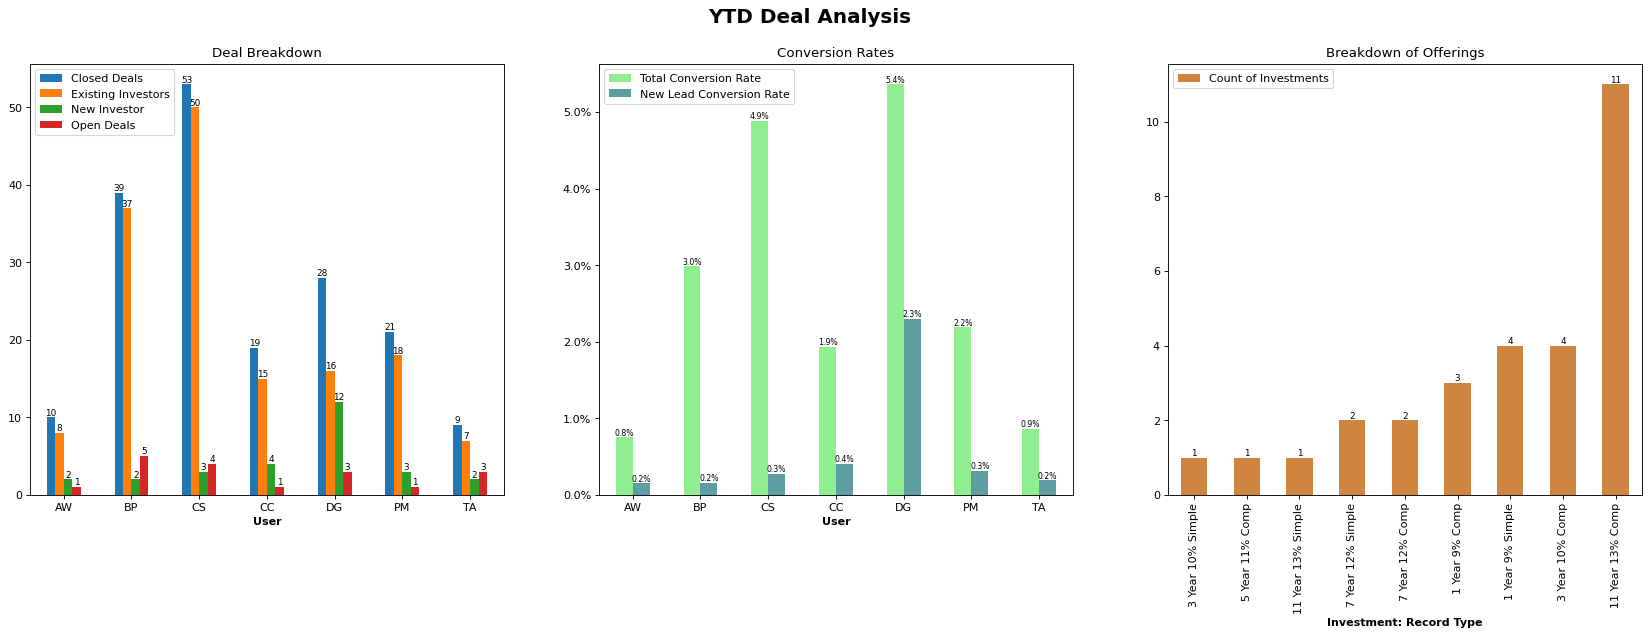

In [193]:
# Draw Stripplot
fig, ax = plt.subplots(1,3, figsize=(26,7), dpi= 80)    
fig.suptitle('YTD Deal Analysis',fontweight="extra bold", fontsize=18, fontfamily='DejaVu Sans')
plt.rcParams["axes.labelweight"] = "bold"
# ax[0].set_title('Correlation Analysis')

# sns.heatmap(conversion_data.corr(),cmap='RdYlGn', center=0, annot=True, ax=ax[0])

ax[0].set_title('Deal Breakdown')
conversion_data.plot.bar(x='User',y=['Closed Deals','Existing Investors','New Investor','Open Deals'],ax=ax[0], stacked=False)
format_bar_labels_count(ax[0],0,'edge')
format_bar_labels_count(ax[0],1,'edge')
format_bar_labels_count(ax[0],2,'edge')
format_bar_labels_count(ax[0],3,'edge')
format_bar_labels_count(ax[0],4,'edge')

ax[1].set_title('Conversion Rates')
conversion_data.plot.bar(ax=ax[1], x='User',y=['Total Conversion Rate','New Lead Conversion Rate'], color=['lightgreen','cadetblue'])
format_bar_labels_percent(ax[1],0,7)
format_bar_labels_percent(ax[1],1,7)

ax[0].legend(ncols=1, loc='upper left')

ax[0].tick_params(axis='x',labelrotation=0)
ax[1].tick_params(axis='x',labelrotation=0)

ticks_00 = ax[1].get_yticks()
new_labels2 = ["{:.1%}".format(x) for x in ticks_00]
ax[1].set(yticklabels=new_labels2) 

ax[2].set_title('Breakdown of Offerings')
record_types.plot.bar(ax=ax[2],x='Investment: Record Type', color='peru')

ax[2].tick_params(axis='x',labelrotation=90)
ax[2].legend(['Count of Investments'])
format_bar_labels_count(ax[2],0,'edge')

plt.show()

In [195]:
todays_date = str(date.today())
save_filename = 'YTD Investment Analysis - ' + todays_date + '.pdf'
unique_filename = cf.write_unique_file(save_filename)
path = 'C:\\Users\\Hannah Nevel\\Documents\\Weekly Reporting - CM\\CM Reports - year to date\\KPI Reporting\\' + unique_filename
with PdfPages(path) as pdf:
    pdf.savefig(fig, bbox_inches='tight')